In [2]:
import glob
import numpy as np
import pandas as pd
import casatasks 
import casatools 
import casadata
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.visualization import AsinhStretch, ImageNormalize
#import ipywidgets as widgets
from analysis_utils import plot_2D_map, fetch_beam_info
import warnings
#%matplotlib widget
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = '{:.3g}'.format

In [3]:
# fetch the image paths
prefix = "/raid/work/yamato/eDisk_data/L1489IRS/v0_images/continuum/L1489IRS_SBLB_continuum_"
ext = ".pbcor.tt0.fits"
robust = [-2.0, -1.0, 0.0, 0.5, 1.0, 2.0]
uvtaper = ['1000klambda', '2000klambda', '3000klambda']

In [4]:
# parameters for noise mask
common_dir = "04h04m43.070001s +26d18m56.20011s" # from imaging script
mask_ra = common_dir.split()[0].replace("h", ":").replace("m", ":").replace("s", "")
mask_dec = common_dir.split()[1].replace("d", ".").replace("m", ".").replace("s", "")
r_in = 6.0 # in arcsec
r_out = 8.0 # in arcsec

# noise annulus as CASA region format
noise_annulus = "annulus[[%s, %s],['%.1farcsec', '%.1farcsec']]" % (mask_ra, mask_dec, r_in, r_out)

# mask for peak measurement
mask_pa = 0.0  # position angle of mask in degrees
mask_maj = 5.0  # semimajor axis of mask in arcsec
mask_min = 5.0  # semiminor axis of mask in arcsec
common_mask = "ellipse[[%s, %s], [%.1farcsec, %.1farcsec], %.1fdeg]" % (mask_ra, mask_dec, mask_maj, mask_min, mask_pa)

# mask for ring 
r_in_central = 0.15
ring_annulus = "annulus[[%s, %s],['%.2farcsec', '%.2farcsec']]" % (mask_ra, mask_dec, r_in_central, r_in)

In [5]:
stat = pd.DataFrame(columns=['bmaj [arcsec]', 'bmin [arcsec]', 'bpa [deg]', 'rms [mJy / beam]', 'Flux density [mJy]', 'Peak intensity [mJy / beam]', 'Peak intensity at ring [mJy / beam]',  'Peak SNR', 'Peak SNR at ring'])

for r in robust:
    imagepath = prefix + 'robust_{:s}'.format(str(r)) + ext
    # fetch beam
    bmaj, bmin, bpa = fetch_beam_info(imagepath)

    # measure rms
    rms = casatasks.imstat(imagepath, region=noise_annulus)["rms"][0]
    s = casatasks.imstat(imagepath, region=common_mask)
    peak_central = s['max'][0]
    flux = s['flux'][0]
    peak_ring = casatasks.imstat(imagepath, region=ring_annulus)['max'][0]
    SNR_central = peak_central / rms
    SNR_ring = peak_ring / rms
    stat.loc['robust_{:s}'.format(str(r))] = [bmaj, bmin, bpa, rms*1e3, flux*1e3, peak_central*1e3, peak_ring*1e3, SNR_central, SNR_ring]
stat_ronly = stat

....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%


In [5]:
# with uvtaper
for r in [1.0, 2.0]:
    for taper in uvtaper:
        # fetch beam
        bmaj, bmin, bpa = fetch_beam_info(imagepath)

        # measure rms
        imagepath = prefix + 'robust_{:s}_taper_{:s}'.format(str(r), taper) + ext
        rms = casatasks.imstat(imagepath, region=noise_annulus)["rms"][0]
        s = casatasks.imstat(imagepath, region=common_mask)
        peak_central = s['max'][0]
        flux = s['flux'][0]
        peak_ring = casatasks.imstat(imagepath, region=ring_annulus)['max'][0]
        SNR_central = peak_central / rms
        SNR_ring = peak_ring / rms
        stat.loc['robust_{:s}_taper_{:s}'.format(str(r), taper)] = [bmaj, bmin, bpa, rms*1e3, flux*1e3, peak_central*1e3, peak_ring*1e3, SNR_central, SNR_ring]

In [13]:
savefile = "./L1489IRS_cont_statistics.pkl"
stat.to_pickle(savefile)

In [6]:
def plot_map_imaging_param(imaging_param_str):
    warnings.filterwarnings('ignore')
    plt.close()
    imagepath = prefix + imaging_param_str + ext
    header = fits.getheader(imagepath)
    beam = (header['BMAJ']/np.abs(header['CDELT1']), header['BMIN']/np.abs(header['CDELT1']), 90+header['BPA'])
    scale = (50 / 140 / 3600 / header['CDELT1'], '50 au')
    data = fits.getdata(imagepath)[2100:3900,2100:3900] * 1e3 # to mJy
    norm = ImageNormalize(data, vmin=0.0, stretch=AsinhStretch(a=0.03))
    levels = np.array([3, 5, 7, 10, 15, 20, 30, 50, 100, 150, 200]) * stat.at[imaging_param_str, 'rms [mJy / beam]']
    imshow_kw = {'norm': norm, 'cmap': 'inferno'}
    contour_kw = {'levels': levels, "colors": "white", "linewidths": 0.2, "linestyles": "dashed"}
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(header)})
    plot_2D_map(data, ax=ax, beam=beam, scale=scale, imshow_kw=imshow_kw, contour_kw=contour_kw)
    plt.show(fig)
    return

ws = widgets.Dropdown(description="Parameter:", options=stat.index.values.tolist(), disabled=False)
widgets.interact(plot_map_imaging_param, imaging_param_str=ws);

interactive(children=(Dropdown(description='Parameter:', options=('robust_-2.0', 'robust_-1.0', 'robust_0.0', …

# Statistics for continuum images
- Measured RMSs and SNRs for images with different imaging parameters
- Currently we have:
```
    robust = [-2.0, -1.0, 0.0, 0.5, 1.0, 2.0]
    uvtaper = ['1000klambda', '2000klambda', '3000klambda']
```
- uvtaper is only for robust of 1.0 and 2.0
- The peak SNRs at the ring are also measured

In [11]:
stat

,bmaj [arcsec],bmin [arcsec],bpa [deg],rms [mJy / beam],Flux density [mJy],Peak intensity [mJy / beam],Peak intensity at ring [mJy / beam],Peak SNR,Peak SNR at ring
robust_-2.0,0.0407,0.0229,20.4,0.111,3.25,3.6,0.52,32.6,4.71
robust_-1.0,0.0412,0.0235,20.1,0.0613,3.42,3.74,0.285,61,4.64
robust_0.0,0.0477,0.0292,19.3,0.0249,1.46,3.99,0.116,161,4.66
robust_0.5,0.06,0.0358,23.1,0.0191,1.25,4.19,0.114,219,5.95
robust_1.0,0.0806,0.0434,27.7,0.0197,3.41,4.37,0.151,222,7.66
robust_2.0,0.0914,0.0513,28.3,0.0247,3.75,4.48,0.186,182,7.54
robust_1.0_taper_1000klambda,0.0914,0.0513,28.3,0.0296,16.2,4.88,0.84,165,28.3
robust_1.0_taper_2000klambda,0.159,0.129,16.9,0.0234,9.97,4.69,0.272,200,11.6
robust_1.0_taper_3000klambda,0.112,0.0842,24,0.0213,7.17,4.57,0.209,215,9.83
robust_2.0_taper_1000klambda,0.0956,0.0637,28.3,0.037,21.1,4.96,1.16,134,31.3


- beam size ranges ~0.04 - 0.1
- noise levels ranges 0.02 - 0.1 mJy/beam
- robust = 0.5 gives the lowest noise level in mJy/beam
- uvtaper helps recover the extended emission (see flux density differences)
- SNR at the inner disk is ~ 30 - 200
- Emission at the ring is faint; SNR ~ 4 - 28

## beam size vs. rms (in mJy/beam)

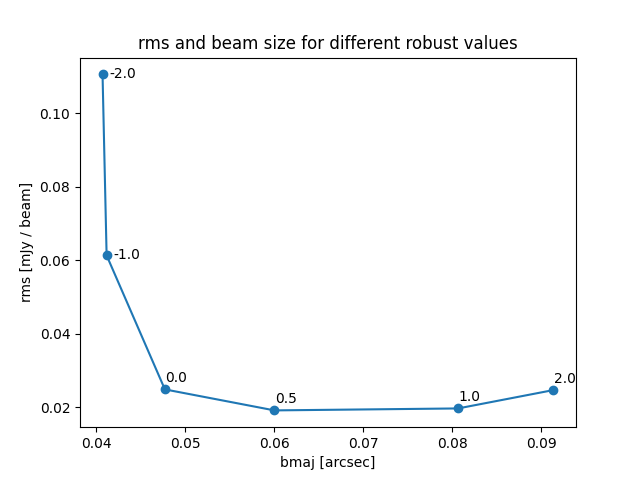

In [33]:
fig, ax = plt.subplots()
x = stat_ronly.loc[:, 'bmaj [arcsec]']
y = stat_ronly.loc[:, 'rms [mJy / beam]']

ax.plot(x, y)
ax.scatter(x, y)
ax.set(xlabel='bmaj [arcsec]', ylabel='rms [mJy / beam]', title='rms and beam size for different robust values')
for i,txt in enumerate(stat_ronly.index.values.tolist()):
    if i < 2:
        ax.annotate(txt.replace('robust_', ''), (x[i], y[i]), ha='left', va='center', xytext=(5,0), textcoords='offset points')
    else:
        ax.annotate(txt.replace('robust_', ''), (x[i], y[i]), ha='left', va='bottom', xytext=(0.5,3), textcoords='offset points')


In [34]:
fig.savefig("./L1489IRS_continuum_stat_bmaj_vs_rms.pdf", bbox_inches='tight', pad_inches=0.01)

## beam size vs. rms (in K)

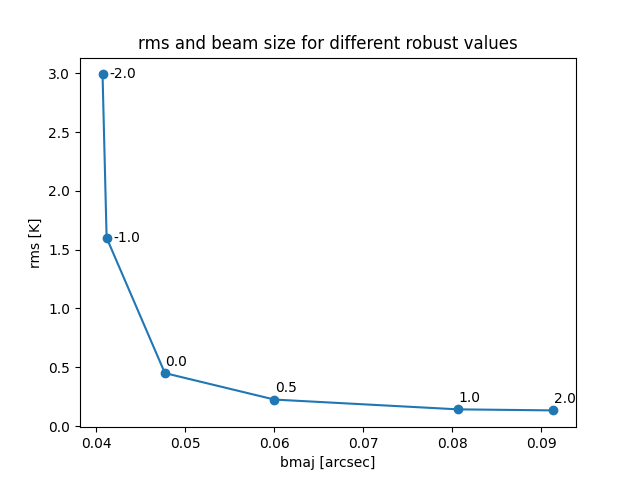

In [35]:
import astropy.units as u
nu0 = 220 * u.GHz
rms = stat_ronly.loc[:, "rms [mJy / beam]"].to_numpy() * u.mJy / u.beam
beam_area = stat_ronly.loc[:, 'bmaj [arcsec]'].to_numpy() * u.arcsec * stat_ronly.loc[:, 'bmin [arcsec]'].to_numpy() * u.arcsec / (8 * np.log(2)) * 2 * np.pi

rms_K = rms.to(u.K, equivalencies=u.brightness_temperature(nu0, beam_area=beam_area)).value

fig, ax = plt.subplots()
x = stat_ronly.loc[:, 'bmaj [arcsec]']

ax.plot(x, rms_K)
ax.scatter(x, rms_K)
ax.set(xlabel='bmaj [arcsec]', ylabel='rms [K]', title='rms and beam size for different robust values')
for i,txt in enumerate(stat_ronly.index.values.tolist()):
    if i < 2:
        ax.annotate(txt.replace('robust_', ''), (x[i], rms_K[i]), ha='left', va='center', xytext=(5,0), textcoords='offset points')
    else:
        ax.annotate(txt.replace('robust_', ''), (x[i], rms_K[i]), ha='left', va='bottom', xytext=(0.5,3), textcoords='offset points')

In [36]:
fig.savefig("./L1489IRS_continuum_stat_bmaj_vs_rms_K.pdf", bbox_inches='tight', pad_inches=0.01)